## Randomization and Covariate Adjustment
_Bryan Graham_
_University of California at Berkeley_  
_January 2019_ (_Updated January 2025_)
<br>
<br>
#### Code citation:
<br>
Graham, Bryan S. (2019). "Randomization and Covariate Adjustment Python Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 27 May 2019)
<br>
<br>
Begin by loading the _ipt_ module. For information about this module, including how to install it, please see this blog [post](http://bryangraham.github.io/econometrics/causal/inference/2016/05/15/IPT-module.html).
We will also need several standard libraries that are all part of the usual Python "scientific stack".

In [1]:
# Append location of ipt module base directory to system path
# NOTE: only required if permanent install not made (see link above)
import sys
sys.path.append('/Users/bgraham/Dropbox/Sites/software/ipt/')

# Load ipt module
import ipt as ipt

In [2]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import numpy.linalg
import scipy as sp

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Adjust the directory assignment below to the location of the course files on your local machine.

In [3]:
datasets = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Data/'
figures =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Graphics/'

We begin by loading the _accidents.pkl_ dataframe. This dataset includes records on $N = 142$ diving accidents. Specifically whether the diver involved in the accident is able to walk normally (_limp_ = 1 if _not_ able to walk normally and zero otherwise). The main type of "accident" faced by lobster/conch divers is decompression sickness. This is caused by too much bottom time and, in serious cases, can cause permanent mobility issues or even paralysis. Also included in the dataset is the diver's report of the depth at which the accident occured and whether he received any medical attention post accident (_treated_ = 1 if received medical attention post-accident and zero otherwise). Also included in the dataframe is a survey sampling weight and village (aldea) of residence codes.

In [4]:
# Read in La Moskitia diving accident dataset & print summary statistics
accidents = pd.read_pickle(datasets + "accidents.pkl") 
print(accidents.describe())

# Since accident depth information is missing for two units, I drop those cases.
# This leaves us with N = 140 complete cases for analysis
accidents = accidents.dropna()

               sw     treated        limp  accident_depth  constant
count  142.000000  142.000000  142.000000      140.000000     142.0
mean     7.708158    0.845070    0.443662      102.685714       1.0
std      4.137631    0.363118    0.498575       25.989507       0.0
min      2.115400    0.000000    0.000000       15.000000       1.0
25%      2.115400    1.000000    0.000000       90.000000       1.0
50%     10.747700    1.000000    0.000000      100.000000       1.0
75%     10.747700    1.000000    1.000000      120.000000       1.0
max     10.747700    1.000000    1.000000      180.000000       1.0


As an initial piece of analysis we form the 2 X 2 contingency table relating a diver's post-accident receipt of medical treatment to their ability to walk normally. We construct the table to report conditional probabilities. The main tool here is the pandas _crosstab_ method. We also use some basic pandas dataframe functionality to make our results pretty.

In [5]:
# Form crosstab of post-accident medical treatment status and walking ability
med_by_limp = pd.crosstab(accidents['limp'], accidents['treated'], \
                          rownames=['Mobility'], colnames=['Treatment'], margins=True)

# Create informative labels for bins and attach them to the cross tabulation 
treatment_labels = ['Control',       'Treated', 'Pr(Y=y)']
walk_labels      = ['Walk normally', 'Limp',    'Pr(W=w)']

# Associate bin labels with cross tabulation
med_by_limp.index   = pd.Index(walk_labels, name="Mobility")
med_by_limp.columns = pd.Index(treatment_labels, name="Treatment")

# Convert cross tabulation into joint frequency distribution 
N   = len(accidents['accident_depth'])           # Total number of accidents
med_by_limp = 100*med_by_limp/N

# Divide by column sums to convert into conditional frequency distribution
med_by_limp.loc[['Walk normally', 'Limp'], ['Control', 'Treated']] = \
    100*(med_by_limp.loc[['Walk normally', 'Limp'], ['Control', 'Treated']]/ \
         med_by_limp.loc['Pr(W=w)',['Control', 'Treated']])

print("Conditional Frequency Distribution of Walking Mobility Given Post-Accident Treatment")
print("")    
print( np.round(med_by_limp,1))  

Conditional Frequency Distribution of Walking Mobility Given Post-Accident Treatment

Treatment      Control  Treated  Pr(Y=y)
Mobility                                
Walk normally     71.4     52.9     55.7
Limp              28.6     47.1     44.3
Pr(W=w)           15.0     85.0    100.0


Observe that almost half of accident victims are unable to walk normally. This means anything from walking with a limp to more-or-less complete paralysis.
<br>
<br>
The table suggests something counter-intuitive. Among those divers that receive medical treatment post accident, 47.1 percent are unable to walk normally. Whereas among those divers that _do not_ receive medical treatment post accident, only 28.6 percent are unable to walk normally. Does post-accident medical attention worsen diver outcomes? This seems unlikely. What is more likely is that the severity of the accident, which we do not directly observe, is strongly correlated with the decision to seek medical treatment. Divers may only seek out medical help for serious accidents. Of course, serious accidents may result in long term mobility issues even with excellent post-accident medical help. We say that unobserved _accident seriousness_ confounds the relationship between medical treatment and walking mobility.
<br>
<br>
Although we do not observe accident severity, we do observe the depth at which the accident occured (as reported by the diver). In general, the severity of decompression sickness is related to depth at which the diving activity took place (as well as the aggregate amount of bottom time). The next snippet of code generates a cross-tab of post-accident medical treatment against accident diving depth. I discretize the latter variable into four bins. This code snippet produces a nice graphical representation of the cross tab, illustrating some of the graphical capabilities of matlibplot, the main graphing library for Python.


Conditional Frequency of Recieving Medical Treatment Given Accident Depth

Accident Depth  [0,75)  [75,100)  [100,125)  +125  Pr(Treatment=t)
Treatment                                                         
Control           50.0      14.3        9.0  15.8             15.0
Treated           50.0      85.7       91.0  84.2             85.0
Pr(Depth=x)        8.6      30.0       47.9  13.6            100.0



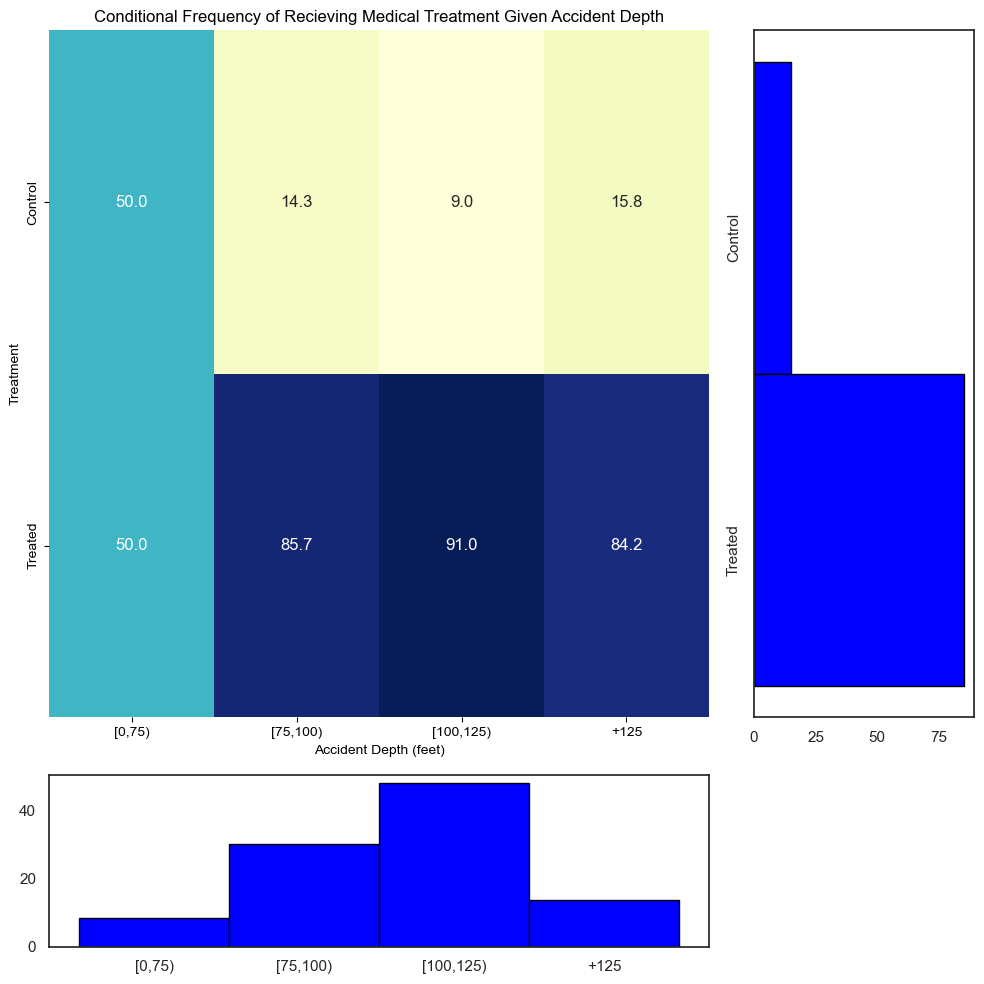

In [6]:
# Accident depth buckets
depth_bkts = [0, 75, 100, 125]

# Form crosstab of post-accident medical treatment status and accident depth
# NOTE: np.digitize() returns bin indices with upper bin edges excluded
depth_by_med = pd.crosstab(accidents['treated'], \
                           np.digitize(accidents['accident_depth'], depth_bkts), \
                           rownames=['Treatment'], colnames=['Accident Depth'], margins=True)

treatment_labels = ['Control', 'Treated', 'Pr(Depth=x)']
depth_bin_labels = ['[0,75)', '[75,100)', '[100,125)', '+125', 'Pr(Treatment=t)']

# Associate bin labels with cross tabulation
depth_by_med.index   = pd.Index(treatment_labels, name="Treatment")
depth_by_med.columns = pd.Index(depth_bin_labels, name="Accident Depth")
                                     
# Convert cross tabulation into joint frequency distribution 
N   = len(accidents['accident_depth'])           # Total number of accidents
depth_by_med = 100*depth_by_med/N

# Divide by column sums to convert into conditional frequency distribution
depth_by_med.loc[['Control', 'Treated'],['[0,75)', '[75,100)', '[100,125)', '+125']] = \
    100*(depth_by_med.loc[['Control', 'Treated'],['[0,75)', '[75,100)', '[100,125)', '+125']]/ \
         depth_by_med.loc['Pr(Depth=x)',['[0,75)', '[75,100)', '[100,125)', '+125']])
    
print("")
print("Conditional Frequency of Recieving Medical Treatment Given Accident Depth")
print("")
print(np.round(depth_by_med,1))
print("")

# Form a plot with a heatmap of the conditional frequency distribution at the center and histograms
# of the two marginal frequency distributions on each side.
import matplotlib.gridspec as gridspec

# Create figure; use gridspec to control relative size of three subplots
cfd_fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4,1]) 

# Prepare conditional and marginal frequency distributions for plotting
cfd       = depth_by_med.loc[['Control', 'Treated'],['[0,75)', '[75,100)', '[100,125)', '+125']]
mfd_depth = np.asarray(depth_by_med.loc[['Pr(Depth=x)'],['[0,75)', '[75,100)', '[100,125)', '+125']])
mfd_treat = np.asarray(depth_by_med.loc[['Control', 'Treated'],['Pr(Treatment=t)']])

mfd_depth = pd.Series(np.ravel(mfd_depth), index=['[0,75)', '[75,100)', '[100,125)', '+125'])
mfd_treat = pd.Series(np.ravel(mfd_treat), index=['Control', 'Treated'])

# Conditional frequency distribution
ax0 = plt.subplot(gs[0])
sns.set(style="white")
sns.heatmap(cfd, cmap="YlGnBu", robust=True, annot=True, fmt=".1f", cbar=False)
plt.title('Conditional Frequency of Recieving Medical Treatment Given Accident Depth')
plt.xlabel('Accident Depth (feet)')
plt.ylabel('Treatment')

# Marginal frequency distribution of treatment
ax1 = plt.subplot(gs[1])
mfd_treat.plot(kind='barh',width=1, facecolor='blue', edgecolor='black').invert_yaxis()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90)
plt.autoscale()

# Marginal frequency distribution of accident depth
ax2 = plt.subplot(gs[2])
mfd_depth.plot(kind='bar',width=1, facecolor='blue', edgecolor='black')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.autoscale()

# Save result
plt.tight_layout()
plt.savefig(figures +"Treatment_by_Accident_Depth.png")

The treatment-by-depth cross-tab indicates that divers are more likely to receive medical attention after accidents associated with deep diving. While only half of divers receive post-accident treatment for accidents occuring at depths of less that 75 feet, almost 85 percent do so when the accident occurs at depths greater than 125 feet.
<br>
<br>
The next snippet of code produces a limp-by-depth cross tab. The format is entirely parallel to the treatment-by-depth cross-tab produced above. The cross tab reveals, as suspected, that accidents at great depths are more likely to result in mobility problems (irrespective of whether medical treatment is received).


Conditional Frequency of Being Able to Walk Normally Given Accident Depth

Accident Depth  [0,75)  [75,100)  [100,125)  +125  Pr(Limp=y)
Mobility                                                     
Walk Normally     58.3      73.8       50.7  31.6        55.7
Limp              41.7      26.2       49.3  68.4        44.3
Pr(Depth=x)        8.6      30.0       47.9  13.6       100.0


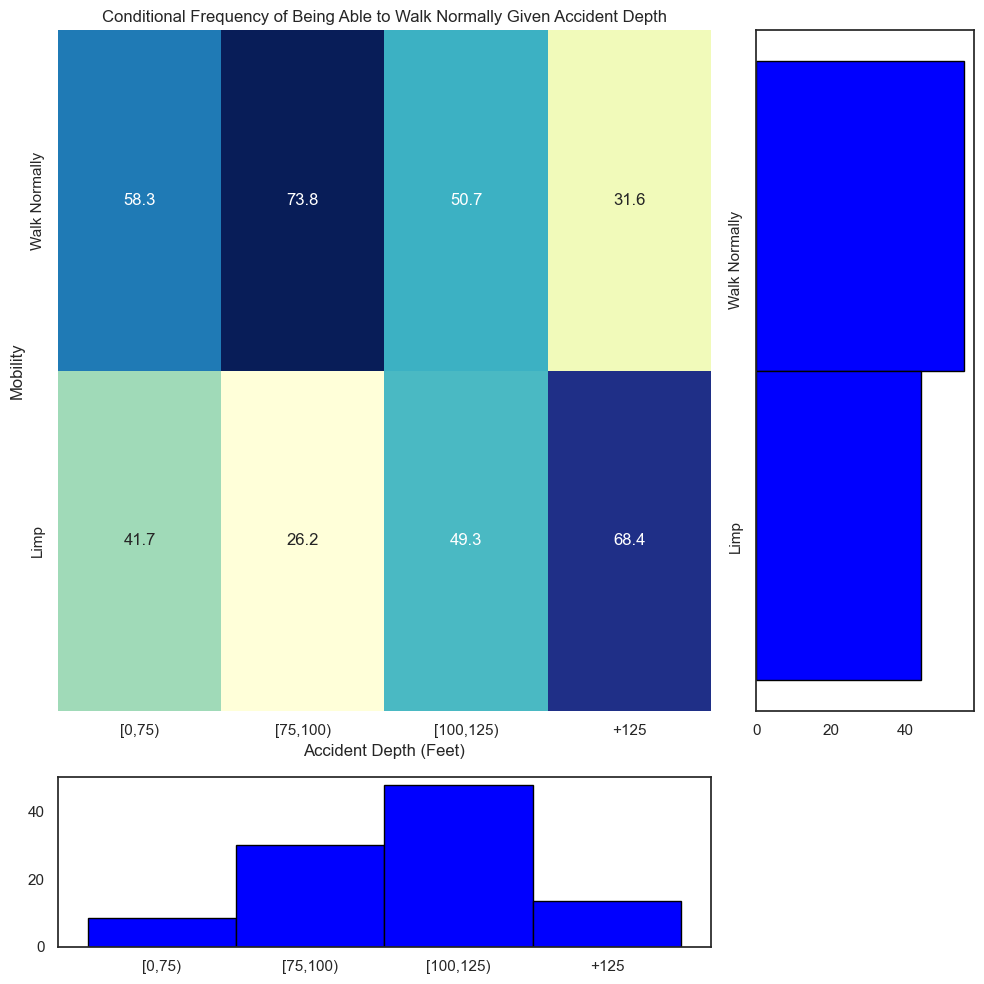

In [7]:
# Form crosstab of post-accident mobility status and accident depth
# NOTE: np.digitize() returns bin indices with upper bin edges excluded
depth_by_limp = pd.crosstab(accidents['limp'], \
                            np.digitize(accidents['accident_depth'], depth_bkts), \
                            rownames=['Mobility'], colnames=['Accident Depth'], margins=True)

treatment_labels = ['Walk Normally', 'Limp', 'Pr(Depth=x)']
depth_bin_labels = ['[0,75)', '[75,100)', '[100,125)', '+125', 'Pr(Limp=y)']

# Associate bin labels with cross tabulation
depth_by_limp.index   = pd.Index(treatment_labels, name="Mobility")
depth_by_limp.columns = pd.Index(depth_bin_labels, name="Accident Depth")
                                     
# Convert cross tabulation into joint frequency distribution 
depth_by_limp = 100*depth_by_limp/N

# Divide by column sums to convert into conditional frequency distribution
depth_by_limp.loc[['Walk Normally', 'Limp'],['[0,75)', '[75,100)', '[100,125)', '+125']] = \
    100*(depth_by_limp.loc[['Walk Normally', 'Limp'],['[0,75)', '[75,100)', '[100,125)', '+125']]/ \
         depth_by_limp.loc['Pr(Depth=x)',['[0,75)', '[75,100)', '[100,125)', '+125']])

print("")
print("Conditional Frequency of Being Able to Walk Normally Given Accident Depth")
print("")    
print(np.round(depth_by_limp,1))  

# Form a plot with a heatmap of the conditional frequency distribution at the center and histograms
# of the two marginal frequency distributions on each side.

# Create figure; use gridspec to control relative size of three subplots
cfd_fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4,1]) 

# Prepare conditional and marginal frequency distributions for plotting
cfd       = depth_by_limp.loc[['Walk Normally', 'Limp'],['[0,75)', '[75,100)', '[100,125)', '+125']]
mfd_depth = np.asarray(depth_by_limp.loc[['Pr(Depth=x)'],['[0,75)', '[75,100)', '[100,125)', '+125']])
mfd_treat = np.asarray(depth_by_limp.loc[['Walk Normally', 'Limp'],['Pr(Limp=y)']])

mfd_depth = pd.Series(np.ravel(mfd_depth), index=['[0,75)', '[75,100)', '[100,125)', '+125'])
mfd_treat = pd.Series(np.ravel(mfd_treat), index=['Walk Normally', 'Limp'])

# Conditional frequency distribution
ax0 = plt.subplot(gs[0])
sns.set(style="white")
sns.heatmap(cfd, cmap="YlGnBu", robust=True, annot=True, fmt=".1f", cbar=False)
plt.title('Conditional Frequency of Being Able to Walk Normally Given Accident Depth')
plt.xlabel('Accident Depth (Feet)')
plt.ylabel('Mobility')

# Marginal frequency distribution of being able to walk normally
ax1 = plt.subplot(gs[1])
mfd_treat.plot(kind='barh',width=1, facecolor='blue', edgecolor='black').invert_yaxis()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90)
plt.autoscale()

# Marginal frequency distribution of accident depth
ax2 = plt.subplot(gs[2])
mfd_depth.plot(kind='bar',width=1, facecolor='blue', edgecolor='black')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.autoscale()

# Save result
plt.tight_layout()
plt.savefig(figures +"Mobility_by_Accident_Depth.png")

Finally we attempt to estimate the Average Treatment Effected on the Treated (ATT) for medical attention. First we present the information in our initial cross-tab in "regression form". Specifically we compute the least squares fit of _limp_ onto a constant and _treated_. We use the survey weights provided in the dataframe to weight our results and also cluster our standard errors at the village level. We use the **ipt.ols()** command for this analysis. This is a "barebones" implementation of OLS that is tailored to the types of applications that typically arise in econometrics. A more complete linear model program is available in the statsmodels library, but I find it somewhat more cumbersome to use.
<br>
<br>
The simple OLS analysis, without any additional controls, suggests that medical attention worsen outcomes. This is, of course, very likely due the presence of the omitted variable _accident severity_. We do not observe this variable directly, but we can try to use the observed measure _accident depth_ as a proxy for severity. To do this we use the **ipt.att()** command which implements the covariate adjustment method of auxiliary-to-study tilting described in Graham, Pinto and Egel (2016, _Journal of Business and Economic Statistics_).
<br>
<br>
It turns out that covariate adjustment does not appear to be "successful" in the present case. This is not surprising. Even among the subset of accidents that occured at identical depths, it seems likely that the receipt of medical attention is correlated with unobserved accident features that also influence whether a diver is able to walk normally afterwards. However the example provides a simple example of the mechanics of covariate adjustment and, specifically, how to use the **ipt.att()** command.

In [8]:
# Treatment indicator
D = accidents['treated']

# Balancing moments
t_W                    = accidents['constant'].to_frame()
t_W['accident_depth']  = accidents['accident_depth']/100
t_W['[0,75)']          = (accidents['accident_depth'] < 75)*1
t_W['[75,100)']        = ((accidents['accident_depth'] >= 75) & (accidents['accident_depth'] < 100))*1
t_W['[100,125)']       = ((accidents['accident_depth'] >= 100) & (accidents['accident_depth'] < 125))*1

# Outcome
Y = accidents['limp']

# Clustering variable
v_id = pd.factorize(accidents['village'])[0]
v_id = pd.Series(v_id, name = 'village')

# Unadjusted treatment vs. control contracts
[beta_hat,vcov_hat, _, _, _, _] = ipt.ols(Y, accidents[['constant','treated']], c_id=v_id, s_wgt=accidents['sw'], \
                              nocons=True, silent=False)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Compute AST estimate of ATT
[gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
            ipt.att(D, Y, t_W, t_W, study_tilt=False, rlgrz=0.5, c_id=v_id, s_wgt=accidents['sw'], \
                    nocons=True, silent=False)


-----------------------------------------------------------------------
-                     OLS ESTIMATION RESULTS                          -
-----------------------------------------------------------------------
Dependent variable:        limp
Number of observations, n: 140



Independent variable       Coef.    ( Std. Err.)     (0.95 Confid. Interval )
-------------------------------------------------------------------------------------------
constant                   0.129025 (  0.082746)     ( -0.033155 ,  0.291205)
treated                    0.248709 (  0.104553)     (  0.043789 ,  0.453629)

-------------------------------------------------------------------------------------------
NOTE: Cluster-robust standard errors reported
      Cluster-variable   = village
      Number of clusters = 23
NOTE: (Sampling) Weighted estimates computed.
      Weight-variable   = sw

--------------------------------------------------------------
- Computing propensity score by MLE             

The balance table reported at the end of the **ipt.att()** outcome gives a nice summary of how the method works. While treatment and controls are imbalanced across various moments of the accident depth control, after-reweighting we get "perfect balance" of the chosen moments. While we do not recover a beneficial treatment effect of medical attention, we do recover one that is close to zero (which is much more realistic than the "medicine harms you" implication of the uncontrolled comparison). So, in this case, controlling for accident depth does appear to eliminate some "selection bias", albeit probably not enough to give a causal interpretation to any our results.

In [9]:
# This imports an attractive notebook style from Github
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen('http://bit.ly/1Bf5Hft')
HTML(html.read().decode('utf-8'))